In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
import helpfunction as helper
from __future__ import division

import collections
import NuCC_function as NuCC

Welcome to JupyROOT 6.10/08


In [2]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [3]:
# Load input files

inputdir = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/'
outputdir = inputdir+'NumuCC_crtcut_V/' 
outputdir_png, outputdir_root = NuCC.prepareOutput(outputdir)

filename_overlay = 'NuCCana_overlay_V.root'
filename_data = 'NuCCana_data_V.root'
filename_ext = 'NuCCana_ext_V.root'
filename_dirt = 'NuCCana_dirt_V.root'
    
tree_name = 'numuCCAna'

In [4]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)

pot_data =      8.039e+18 # tor860_wcut
data_trigger = 1942081.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  22622263.0  #2120135 #5685315 # EXT
'''
pot_data =     1.25795274297e+18# tor860_wcut
data_trigger = 1359818.0*0.4 # E1DCNT
ext_trigger =  1359818.0  #2120135 #5685315 # EXT
pot_overlay = 1.25795274297e+18/0.5
pot_dirt = 1.25795274297e18/0.04
'''
print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]*1.3
scale[overlay] = scale[overlay]*1.3

print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	966222
Data: Number of Entries:	34835
Ext: Number of Entries:		263935
Dirt: Number of Entries:	96465

POT: 
Data:		8.039e+18
Ext:		0
Overlay:	1.21058333557e+21
Dirt:		2.9866803255e+20

Scalefactors: 
Data:		1.0
Ext:		0.0858482195172
Overlay:	0.00863278032409
Dirt:		0.0349910230123


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [5]:
if 1:
    filename_overlay = 'NuCCana_overlay_V.rootout.root'
    filename_data = 'NuCCana_data_V.rootout.root'
    filename_ext = 'NuCCana_ext_V.rootout.root'
    filename_dirt = 'NuCCana_dirt_V.rootout.root'

    tree_name = 't_out'

    data, ext, dirt, overlay = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data,ext,dirt,overlay)

    sample = [data,ext,overlay,dirt]
    scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
    name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

    scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale[dirt] = scale[dirt]*1.3
    scale[overlay] = scale[overlay]*1.3


Overlay: Number of Entries:	966221
Data: Number of Entries:	34834
Ext: Number of Entries:		263934
Dirt: Number of Entries:	96464



In [6]:
# Define signals

fidVol = '(Nu_Vx>(-1.55+10) && Nu_Vx<(254.8-10)) && (Nu_Vy>(-115.53+10) && Nu_Vy<(117.47-10)) &&(Nu_Vz>(-0.1+10) && Nu_Vz<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG==13 && MCle_purity>0.5' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG!=13 && MCle_purity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_purity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [7]:
# Load the global variables for access of functions

NuCC.loadGlobal(data,ext,dirt,overlay,scale,tot_num_fidVol,overlay_signals,sample, name, outputdir_png, outputdir_root)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [8]:
# Print initial efficiency and purity

#NuCC.printEff('muon')

In [9]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [10]:
# Define CRT cut

data.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")

track_start_border_x = '(TrackStart_x <(-1.55+5) || TrackStart_x > (254.8-5))'
track_end_border_x = '(TrackEnd_x <(-1.55+5) || TrackEnd_x > (254.8-5))'
track_start_border_y = '(TrackStart_y <(-115.53+5) || TrackStart_y > (117.47-5))'
track_end_border_y = '(TrackEnd_y <(-115.53+5) || TrackEnd_y > (117.47-5))'
track_start_border_z = '(TrackStart_z <(0.1+5) || TrackStart_z > (1036.9-5))'
track_end_border_z = '(TrackEnd_z <(0.1+5) || TrackEnd_z > (1039.9-5))'

track_end_uncontained = track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)



True

In [11]:
NuCC.printEff('fidVol && muon')

Rejection on each sample:
Keep of    data:	100.00%	 reject:	0.00%
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:		100.00%
Purity:			33.35%
Purity*Efficiency	33.35

Amount of    data:	107.74%
Amount of     ext:	37.00%
Amount of overlay:	57.91%
Amount of    dirt:	5.09%

Signal definition=  numu_lowpur: 2.10%	(3.63%)
Signal definition=   numu_other: 0.48%	(0.83%)
Signal definition=    numu_nomu: 4.34%	(7.50%)
Signal definition=      numu_ov: 10.79%	(18.64%)
Signal definition=  numu_signal: 33.35%	(57.58%)
Signal definition=      numu_nc: 6.83%	(11.80%)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//png/CRTTime_corr.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//root/CRTTime_corr.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_signal (Potential memory leak).
Warning in <TROOT::Append>: R

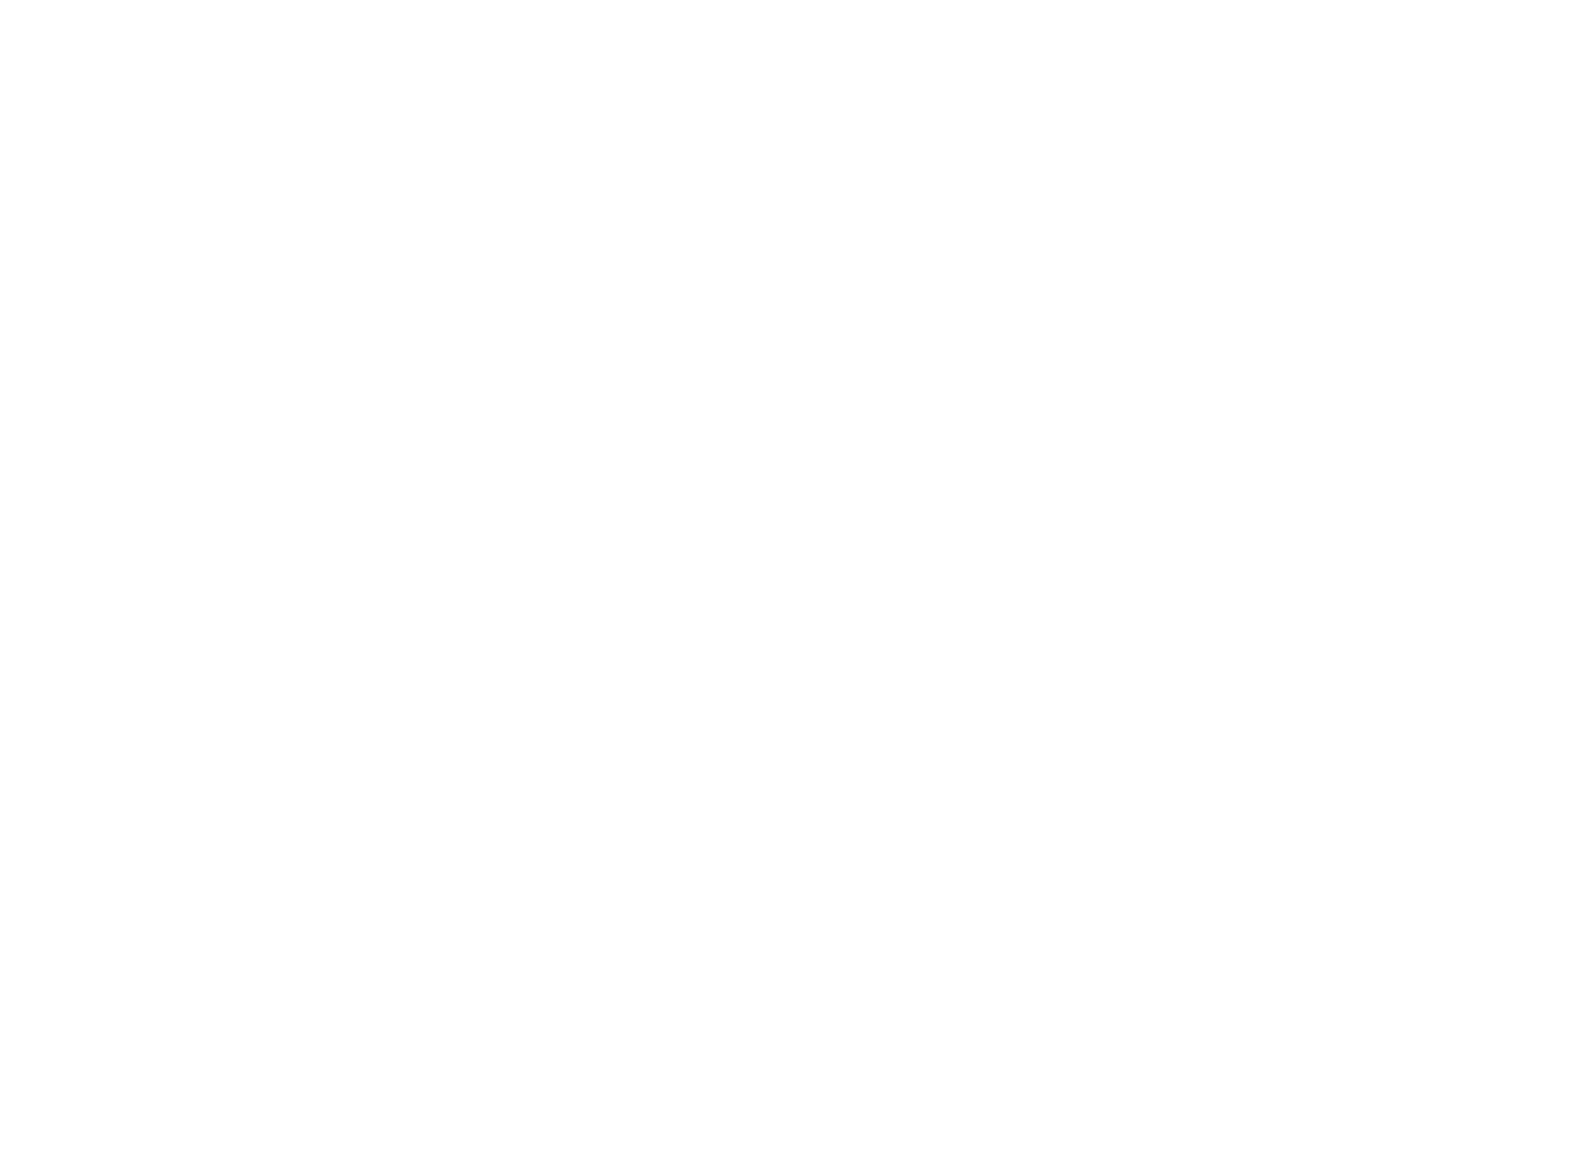

In [24]:
NuCC.make_stacked_histo_plot_crtcorr('fidVol && muon','crthit_ts0','CRT hit time [us]',2.3,5.9,40,'CRTTime_corr')
NuCC.make_stacked_histo_plot_crtcorr('fidVol && muon && !track_end_uncontained','crthit_ts0','CRT hit time [us]',2.3,5.9,40,'CRTTime_corr_cont')
NuCC.make_stacked_histo_plot_crtcorr('fidVol && muon && track_end_uncontained','crthit_ts0','CRT hit time [us]',2.3,5.9,40,'CRTTime_corr_uncont')

Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nc (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//png/CRTTime_corr_tres.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00

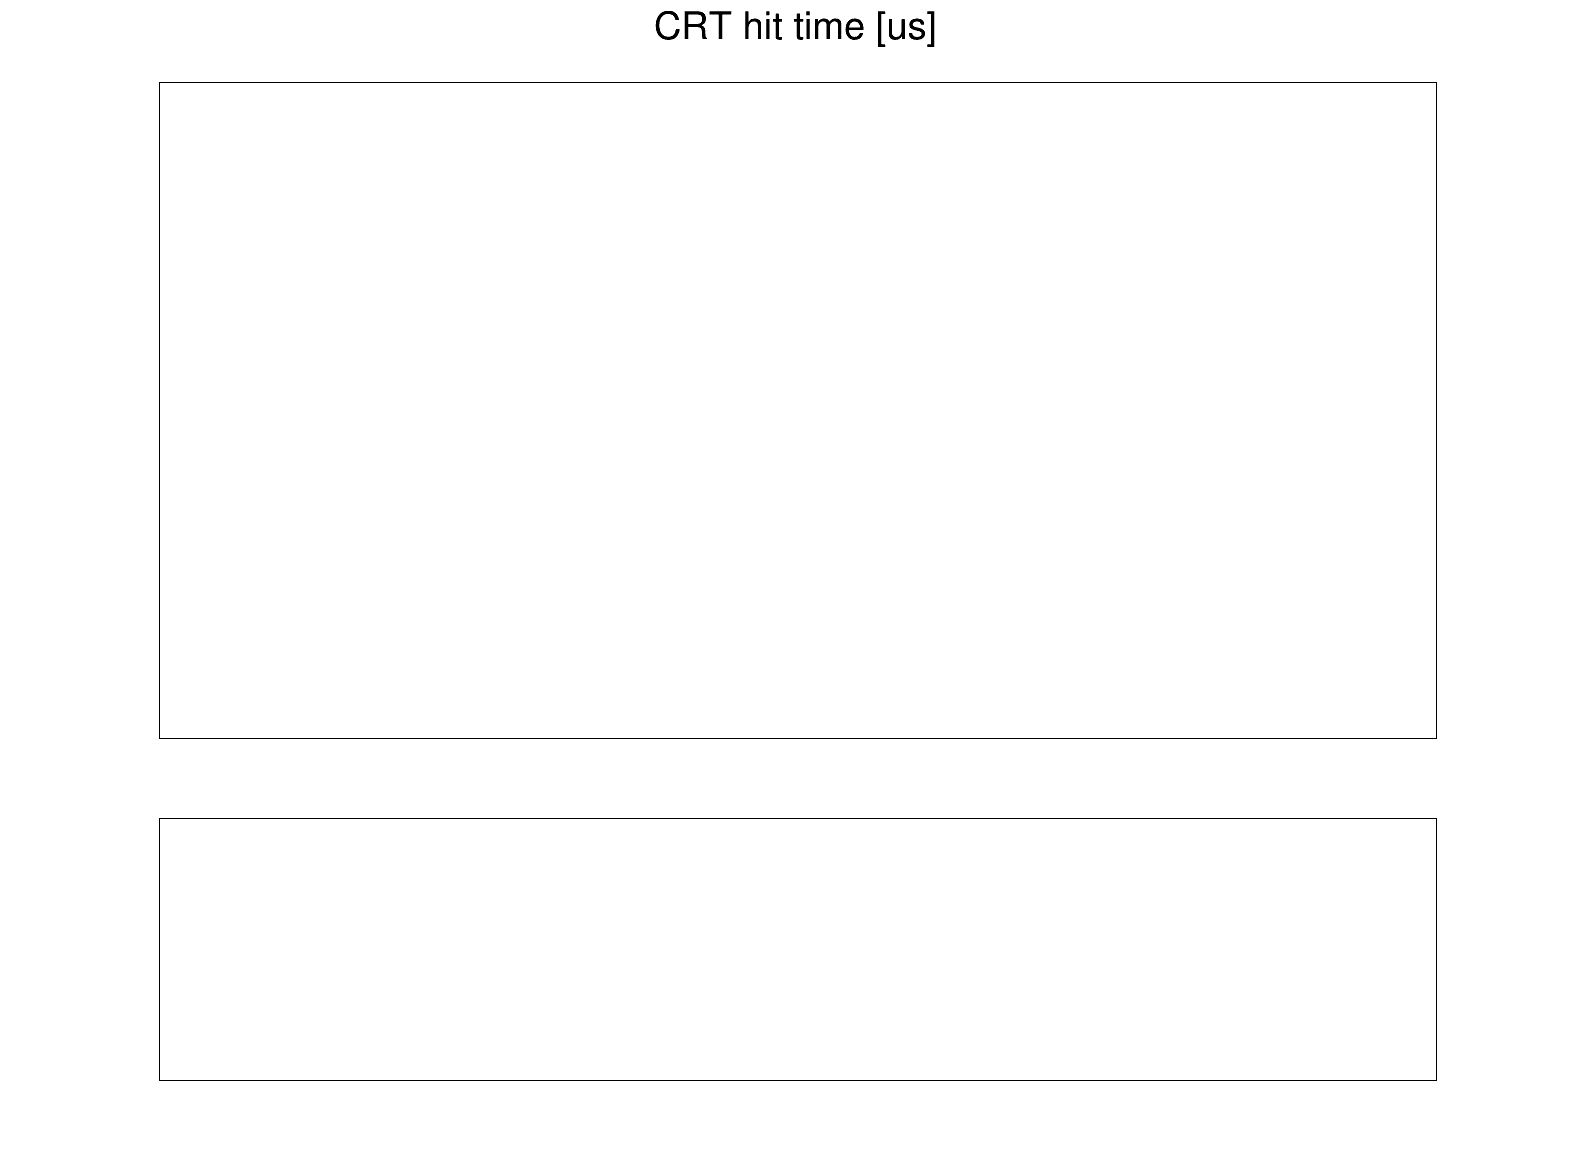

In [25]:
NuCC.make_stacked_histo_plot_crtcorr('fidVol && muon && crt_adc>70','crthit_ts0','CRT hit time [us]',2.3,5.9,40,'CRTTime_corr_tres')
NuCC.make_stacked_histo_plot_crtcorr('fidVol && muon && !track_end_uncontained && crt_adc>70','crthit_ts0','CRT hit time [us]',2.3,5.9,40,'CRTTime_corr_cont_tres')
NuCC.make_stacked_histo_plot_crtcorr('fidVol && muon && track_end_uncontained && crt_adc>70','crthit_ts0','CRT hit time [us]',2.3,5.9,40,'CRTTime_corr_uncont_tres')

In [20]:
NuCC.printEff('fidVol && muon && nr_crthit_beam_tres<1')

Rejection on each sample:
Keep of    data:	66.26%	 reject:	33.74%
Keep of     ext:	53.26%	 reject:	46.74%
Keep of overlay:	86.30%	 reject:	13.70%
Keep of    dirt:	69.43%	 reject:	30.57%

Efficiency:		86.94%
Purity:			39.60%
Purity*Efficiency	34.43

Amount of    data:	97.50%
Amount of     ext:	26.91%
Amount of overlay:	68.26%
Amount of    dirt:	4.83%

Signal definition=  numu_lowpur: 2.46%	(3.60%)
Signal definition=   numu_other: 0.60%	(0.88%)
Signal definition=    numu_nomu: 4.76%	(6.98%)
Signal definition=      numu_ov: 11.82%	(17.31%)
Signal definition=  numu_signal: 39.60%	(58.01%)
Signal definition=      numu_nc: 9.01%	(13.19%)


In [14]:
NuCC.printEff('fidVol && muon && !track_end_uncontained')

Rejection on each sample:
Keep of    data:	61.27%	 reject:	38.73%
Keep of     ext:	57.53%	 reject:	42.47%
Keep of overlay:	62.80%	 reject:	37.20%
Keep of    dirt:	65.67%	 reject:	34.33%

Efficiency:		52.83%
Purity:			28.88%
Purity*Efficiency	15.26

Amount of    data:	108.23%
Amount of     ext:	34.89%
Amount of overlay:	59.62%
Amount of    dirt:	5.48%

Signal definition=  numu_lowpur: 2.29%	(3.84%)
Signal definition=   numu_other: 0.54%	(0.90%)
Signal definition=    numu_nomu: 6.43%	(10.79%)
Signal definition=      numu_ov: 11.34%	(19.02%)
Signal definition=  numu_signal: 28.88%	(48.44%)
Signal definition=      numu_nc: 10.12%	(16.98%)


In [11]:
NuCC.printEff('fidVol && muon && track_uncontained==0')

Rejection on each sample:
Keep of    data:	61.27%	 reject:	38.73%
Keep of     ext:	57.53%	 reject:	42.47%
Keep of overlay:	62.80%	 reject:	37.20%
Keep of    dirt:	65.67%	 reject:	34.33%

Efficiency:		52.83%
Purity:			28.88%
Purity*Efficiency	15.26

Amount of    data:	108.23%
Amount of     ext:	34.89%
Amount of overlay:	59.62%
Amount of    dirt:	5.48%

Signal definition=  numu_lowpur: 2.29%	(3.84%)
Signal definition=   numu_other: 0.54%	(0.90%)
Signal definition=    numu_nomu: 6.43%	(10.79%)
Signal definition=      numu_ov: 11.34%	(19.02%)
Signal definition=  numu_signal: 28.88%	(48.44%)
Signal definition=      numu_nc: 10.12%	(16.98%)


In [15]:
NuCC.printEff('fidVol && muon && track_end_uncontained')

Rejection on each sample:
Keep of    data:	38.73%	 reject:	61.27%
Keep of     ext:	42.47%	 reject:	57.53%
Keep of overlay:	37.20%	 reject:	62.80%
Keep of    dirt:	34.33%	 reject:	65.67%

Efficiency:		47.17%
Purity:			40.33%
Purity*Efficiency	19.02

Amount of    data:	106.99%
Amount of     ext:	40.29%
Amount of overlay:	55.23%
Amount of    dirt:	4.48%

Signal definition=  numu_lowpur: 1.80%	(3.27%)
Signal definition=   numu_other: 0.40%	(0.72%)
Signal definition=    numu_nomu: 1.07%	(1.95%)
Signal definition=      numu_ov: 9.94%	(18.00%)
Signal definition=  numu_signal: 40.33%	(73.02%)
Signal definition=      numu_nc: 1.69%	(3.06%)


In [14]:
NuCC.printEff_sample('fidVol && muon','!track_end_uncontained &&')

Rejection on each sample:
Keep of    data:	100.00%	 reject:	0.00%
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:		100.00%
Purity:			28.88%
Purity*Efficiency	28.88

Amount of    data:	108.23%
Amount of     ext:	34.89%
Amount of overlay:	59.62%
Amount of    dirt:	5.48%

Signal definition=  numu_lowpur: 2.29%	(3.84%)
Signal definition=   numu_other: 0.54%	(0.90%)
Signal definition=    numu_nomu: 6.43%	(10.79%)
Signal definition=      numu_ov: 11.34%	(19.02%)
Signal definition=  numu_signal: 28.88%	(48.44%)
Signal definition=      numu_nc: 10.12%	(16.98%)


In [13]:
NuCC.printEff_sample('fidVol && muon','track_end_uncontained &&')

Rejection on each sample:
Keep of    data:	100.00%	 reject:	0.00%
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:		100.00%
Purity:			40.33%
Purity*Efficiency	40.33

Amount of    data:	106.99%
Amount of     ext:	40.29%
Amount of overlay:	55.23%
Amount of    dirt:	4.48%

Signal definition=  numu_lowpur: 1.80%	(3.27%)
Signal definition=   numu_other: 0.40%	(0.72%)
Signal definition=    numu_nomu: 1.07%	(1.95%)
Signal definition=      numu_ov: 9.94%	(18.00%)
Signal definition=  numu_signal: 40.33%	(73.02%)
Signal definition=      numu_nc: 1.69%	(3.06%)


In [14]:
NuCC.printEff_sample('fidVol && muon && nr_crthit_beam_tres<1','!track_end_uncontained &&')

Rejection on each sample:
Keep of    data:	68.38%	 reject:	31.62%
Keep of     ext:	52.23%	 reject:	47.77%
Keep of overlay:	90.34%	 reject:	9.66%
Keep of    dirt:	71.47%	 reject:	28.53%

Efficiency:		94.53%
Purity:			35.92%
Purity*Efficiency	33.96

Amount of    data:	97.36%
Amount of     ext:	23.98%
Amount of overlay:	70.87%
Amount of    dirt:	5.15%

Signal definition=  numu_lowpur: 2.57%	(3.63%)
Signal definition=   numu_other: 0.67%	(0.94%)
Signal definition=    numu_nomu: 6.78%	(9.57%)
Signal definition=      numu_ov: 12.02%	(16.96%)
Signal definition=  numu_signal: 35.92%	(50.69%)
Signal definition=      numu_nc: 12.89%	(18.19%)


In [13]:
NuCC.printEff_sample('fidVol && muon && nr_crthit_beam_tres<1','nr_tracks_uncontained==0 &&')

Rejection on each sample:
Keep of    data:	68.83%	 reject:	31.17%
Keep of     ext:	52.38%	 reject:	47.62%
Keep of overlay:	91.65%	 reject:	8.35%
Keep of    dirt:	71.51%	 reject:	28.49%

Efficiency:		94.72%
Purity:			36.46%
Purity*Efficiency	34.54

Amount of    data:	97.35%
Amount of     ext:	24.38%
Amount of overlay:	70.59%
Amount of    dirt:	5.03%

Signal definition=  numu_lowpur: 2.32%	(3.28%)
Signal definition=   numu_other: 0.70%	(0.98%)
Signal definition=    numu_nomu: 5.59%	(7.92%)
Signal definition=      numu_ov: 11.79%	(16.71%)
Signal definition=  numu_signal: 36.46%	(51.65%)
Signal definition=      numu_nc: 13.71%	(19.43%)


In [12]:
NuCC.printEff('fidVol && muon && (nr_crthit_beam_tres<1 || track_end_uncontained)')

Rejection on each sample:
Keep of    data:	80.62%	 reject:	19.38%
Keep of     ext:	72.52%	 reject:	27.48%
Keep of overlay:	93.93%	 reject:	6.07%
Keep of    dirt:	81.27%	 reject:	18.73%

Efficiency:		97.11%
Purity:			37.94%
Purity*Efficiency	36.84

Amount of    data:	101.76%
Amount of     ext:	31.43%
Amount of overlay:	63.72%
Amount of    dirt:	4.85%

Signal definition=  numu_lowpur: 2.22%	(3.48%)
Signal definition=   numu_other: 0.54%	(0.85%)
Signal definition=    numu_nomu: 4.17%	(6.55%)
Signal definition=      numu_ov: 11.07%	(17.37%)
Signal definition=  numu_signal: 37.94%	(59.53%)
Signal definition=      numu_nc: 7.77%	(12.19%)


In [15]:
NuCC.printEff('fidVol && muon && (nr_crthit_beam_tres<1 || nr_tracks_uncontained>0)')

Rejection on each sample:
Keep of    data:	82.67%	 reject:	17.33%
Keep of     ext:	74.63%	 reject:	25.37%
Keep of overlay:	95.30%	 reject:	4.70%
Keep of    dirt:	83.33%	 reject:	16.67%

Efficiency:		97.42%
Purity:			37.32%
Purity*Efficiency	36.36

Amount of    data:	102.34%
Amount of     ext:	31.72%
Amount of overlay:	63.40%
Amount of    dirt:	4.87%

Signal definition=  numu_lowpur: 2.25%	(3.55%)
Signal definition=   numu_other: 0.54%	(0.85%)
Signal definition=    numu_nomu: 4.63%	(7.30%)
Signal definition=      numu_ov: 11.02%	(17.38%)
Signal definition=  numu_signal: 37.32%	(58.87%)
Signal definition=      numu_nc: 7.64%	(12.04%)


In [16]:
NuCC.printEff_sample('fidVol && muon && crt_cut','track_end_uncontained &&')

Rejection on each sample:
Keep of    data:	88.67%	 reject:	11.33%
Keep of     ext:	82.94%	 reject:	17.06%
Keep of overlay:	92.76%	 reject:	7.24%
Keep of    dirt:	86.89%	 reject:	13.11%

Efficiency:		96.35%
Purity:			43.89%
Purity*Efficiency	42.29

Amount of    data:	107.14%
Amount of     ext:	37.74%
Amount of overlay:	57.86%
Amount of    dirt:	4.40%

Signal definition=  numu_lowpur: 1.26%	(2.18%)
Signal definition=   numu_other: 0.42%	(0.73%)
Signal definition=    numu_nomu: 1.16%	(2.01%)
Signal definition=      numu_ov: 9.58%	(16.56%)
Signal definition=  numu_signal: 43.89%	(75.85%)
Signal definition=      numu_nc: 1.55%	(2.67%)


In [16]:
NuCC.printEff_sample('fidVol && muon && crt_cut','nr_tracks_uncontained>0 &&')

Rejection on each sample:
Keep of    data:	88.67%	 reject:	11.33%
Keep of     ext:	82.79%	 reject:	17.21%
Keep of overlay:	92.66%	 reject:	7.34%
Keep of    dirt:	86.92%	 reject:	13.08%

Efficiency:		96.37%
Purity:			41.50%
Purity*Efficiency	39.99

Amount of    data:	107.17%
Amount of     ext:	36.15%
Amount of overlay:	59.21%
Amount of    dirt:	4.64%

Signal definition=  numu_lowpur: 1.53%	(2.59%)
Signal definition=   numu_other: 0.41%	(0.69%)
Signal definition=    numu_nomu: 4.05%	(6.84%)
Signal definition=      numu_ov: 9.95%	(16.80%)
Signal definition=  numu_signal: 41.50%	(70.09%)
Signal definition=      numu_nc: 1.76%	(2.97%)


In [18]:
NuCC.printEff_sample('fidVol && muon && nr_track_asso_out_uncon==0','nr_tracks_uncontained>0 &&')

Rejection on each sample:
Keep of    data:	84.80%	 reject:	15.20%
Keep of     ext:	81.54%	 reject:	18.46%
Keep of overlay:	92.03%	 reject:	7.97%
Keep of    dirt:	86.88%	 reject:	13.12%

Efficiency:		95.36%
Purity:			41.46%
Purity*Efficiency	39.53

Amount of    data:	103.49%
Amount of     ext:	35.95%
Amount of overlay:	59.37%
Amount of    dirt:	4.68%

Signal definition=  numu_lowpur: 1.68%	(2.82%)
Signal definition=   numu_other: 0.41%	(0.69%)
Signal definition=    numu_nomu: 4.02%	(6.77%)
Signal definition=      numu_ov: 10.04%	(16.90%)
Signal definition=  numu_signal: 41.46%	(69.83%)
Signal definition=      numu_nc: 1.77%	(2.97%)


In [17]:
NuCC.printEff('fidVol && muon && (nr_crthit_beam_tres<1 || track_end_uncontained) && (!track_end_uncontained || crt_cut)')

Rejection on each sample:
Keep of    data:	76.24%	 reject:	23.76%
Keep of     ext:	65.27%	 reject:	34.73%
Keep of overlay:	91.24%	 reject:	8.76%
Keep of    dirt:	76.76%	 reject:	23.24%

Efficiency:		95.39%
Purity:			39.32%
Purity*Efficiency	37.51

Amount of    data:	101.54%
Amount of     ext:	29.85%
Amount of overlay:	65.32%
Amount of    dirt:	4.83%

Signal definition=  numu_lowpur: 2.01%	(3.08%)
Signal definition=   numu_other: 0.56%	(0.86%)
Signal definition=    numu_nomu: 4.38%	(6.71%)
Signal definition=      numu_ov: 10.98%	(16.81%)
Signal definition=  numu_signal: 39.32%	(60.20%)
Signal definition=      numu_nc: 8.05%	(12.32%)


In [21]:
NuCC.printEff('fidVol && muon && (nr_crthit_beam_tres<1 || nr_tracks_uncontained>0) && (nr_tracks_uncontained==0 || nr_track_asso_out_uncon==0)')

Rejection on each sample:
Keep of    data:	75.92%	 reject:	24.08%
Keep of     ext:	66.00%	 reject:	34.00%
Keep of overlay:	91.81%	 reject:	8.19%
Keep of    dirt:	77.89%	 reject:	22.11%

Efficiency:		95.05%
Purity:			38.86%
Purity*Efficiency	36.94

Amount of    data:	100.30%
Amount of     ext:	29.94%
Amount of overlay:	65.20%
Amount of    dirt:	4.86%

Signal definition=  numu_lowpur: 2.01%	(3.08%)
Signal definition=   numu_other: 0.56%	(0.86%)
Signal definition=    numu_nomu: 4.83%	(7.42%)
Signal definition=      numu_ov: 10.95%	(16.79%)
Signal definition=  numu_signal: 38.86%	(59.61%)
Signal definition=      numu_nc: 7.97%	(12.22%)


In [22]:
NuCC.printEff('fidVol && muon && (nr_crthit_beam_tres<1 || nr_tracks_uncontained>0) && (nr_tracks_uncontained==0 || crt_cut)')

Rejection on each sample:
Keep of    data:	77.64%	 reject:	22.36%
Keep of     ext:	66.59%	 reject:	33.41%
Keep of overlay:	92.09%	 reject:	7.91%
Keep of    dirt:	77.90%	 reject:	22.10%

Efficiency:		95.56%
Purity:			38.90%
Purity*Efficiency	37.17

Amount of    data:	102.10%
Amount of     ext:	30.07%
Amount of overlay:	65.09%
Amount of    dirt:	4.84%

Signal definition=  numu_lowpur: 1.94%	(2.98%)
Signal definition=   numu_other: 0.56%	(0.86%)
Signal definition=    numu_nomu: 4.85%	(7.45%)
Signal definition=      numu_ov: 10.90%	(16.75%)
Signal definition=  numu_signal: 38.90%	(59.76%)
Signal definition=      numu_nc: 7.94%	(12.20%)


Efficiency:	94.53%
Purity:		35.92%


Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//png/h_eff_energy_CRTveto.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//root/h_eff_energy_CRTveto.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta_1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//png/h_eff_theta_CRTveto.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//root/h_eff_theta_CRTveto.root has been created
Warning in <TROO

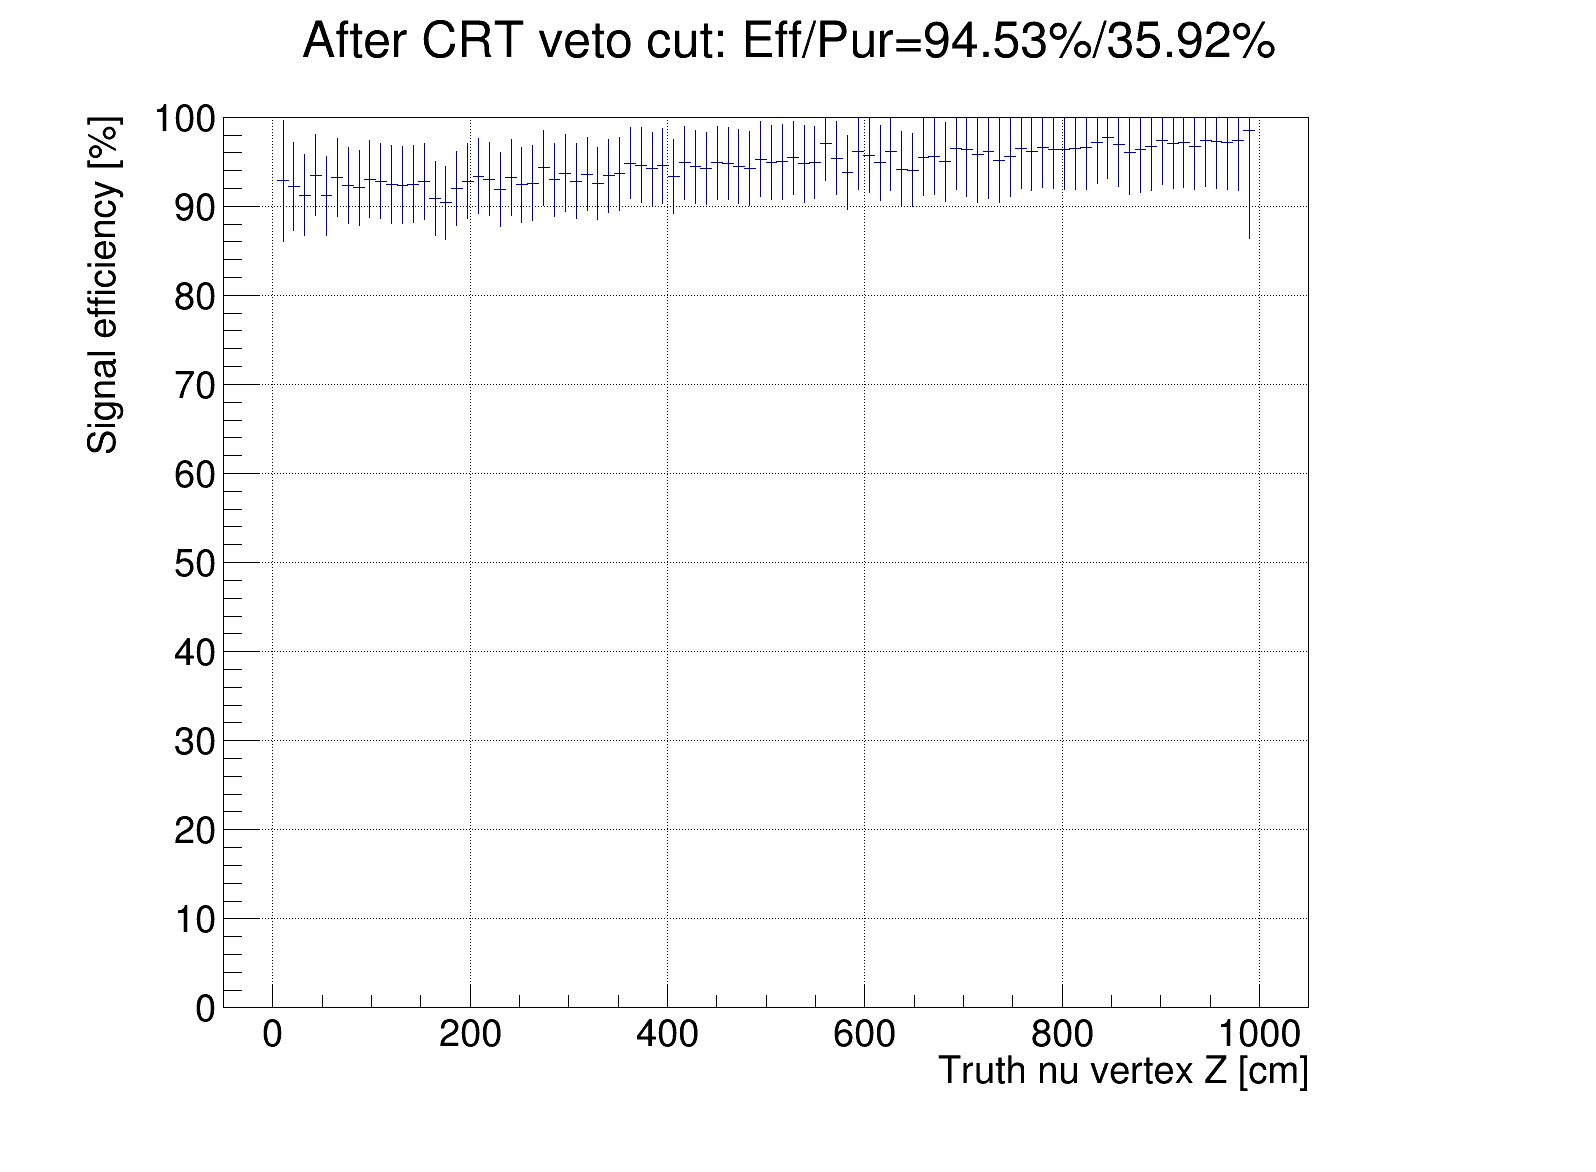

In [14]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && fidVol && !track_end_uncontained"
zahler_cut = "numu_signal && fidVol && muon && (nr_crthit_beam_tres<1) && !track_end_uncontained"
cut = 'fidVol && muon && (nr_crthit_beam_tres<1) && !track_end_uncontained'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)


name = '_CRTveto'
title = 'After CRT veto cut:'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)
h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth enutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)
h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth neutrino cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)
h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco neutrino phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")



In [ ]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && fidVol && !track_end_uncontained"
zahler_cut = "numu_signal && fidVol && muon && (nr_crthit_beam_tres<1) && !track_end_uncontained"
cut = 'fidVol && muon && (nr_crthit_beam_tres<1) && !track_end_uncontained'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)


name = '_CRTveto'
title = 'After CRT veto cut:'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)
h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth enutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)
h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth neutrino cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)
h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco neutrino phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")



Efficiency:	96.35%
Purity:		43.89%


Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//png/h_eff_energy_CRTcut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//root/h_eff_energy_CRTcut.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta_1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//png/h_eff_theta_CRTcut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//root/h_eff_theta_CRTcut.root has been created
Warning in <TROOT::A

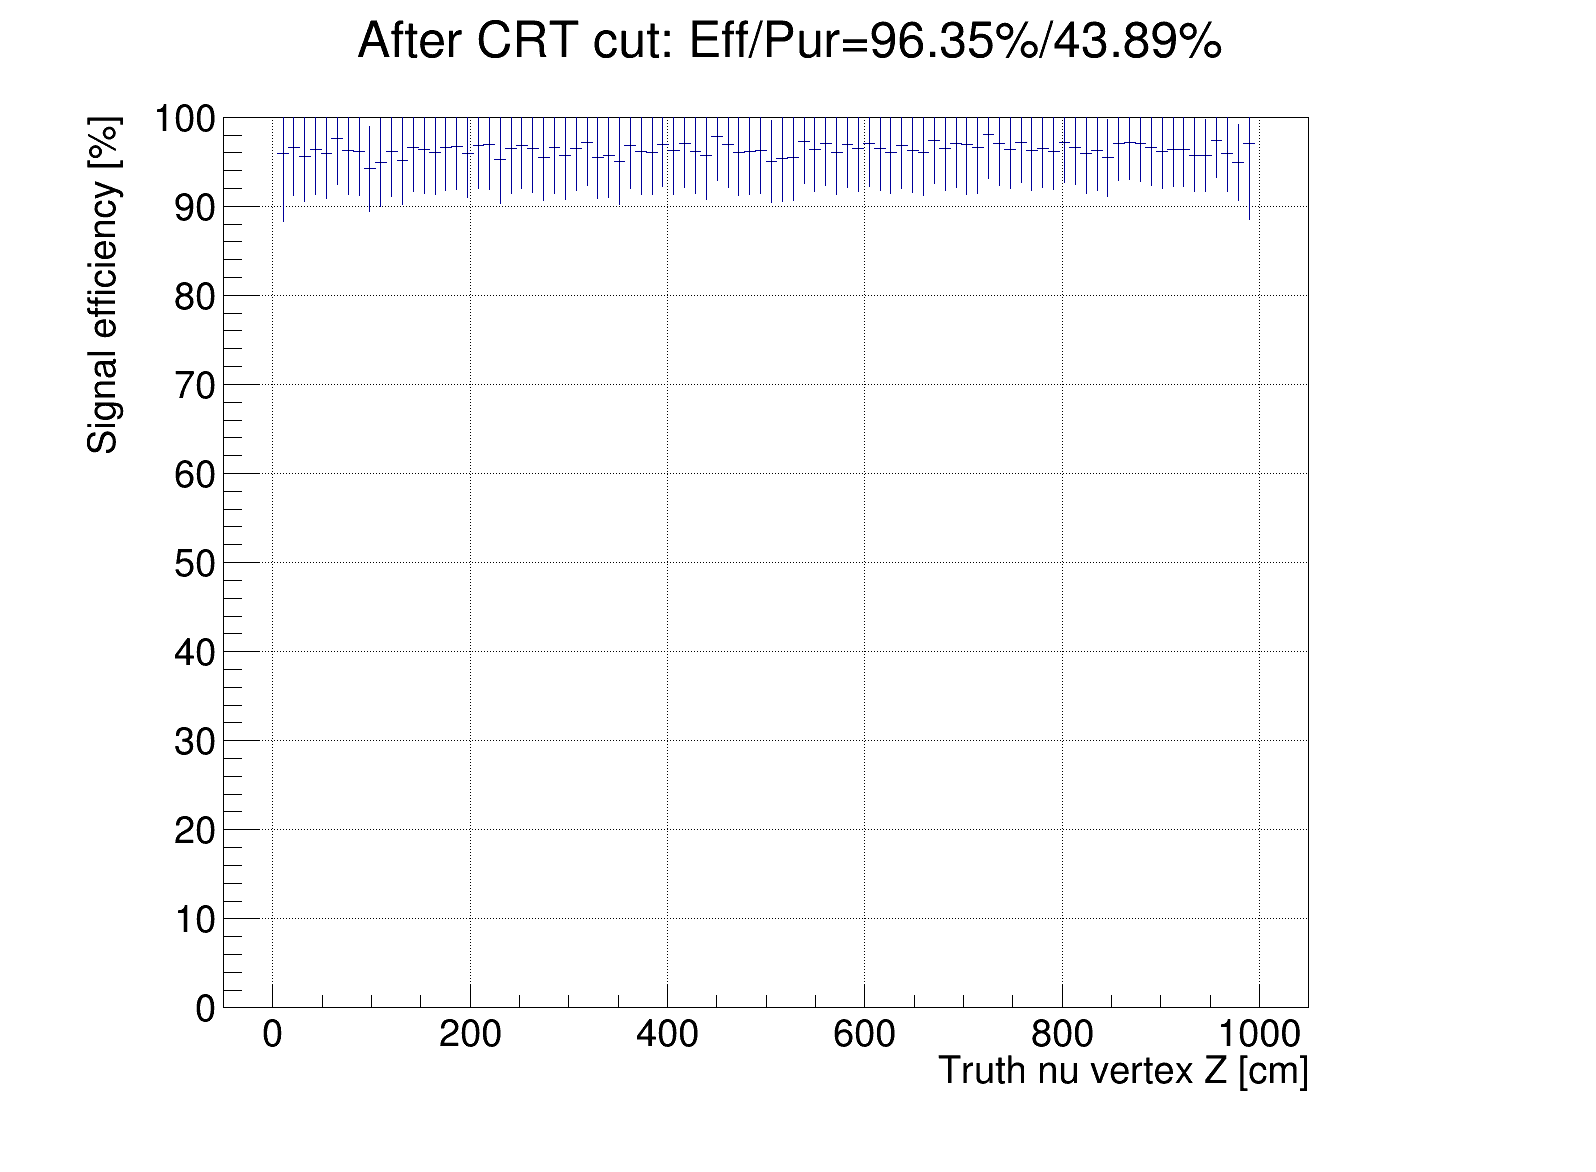

In [18]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && fidVol && track_end_uncontained"
zahler_cut = "numu_signal && fidVol && muon && (crt_cut) && track_end_uncontained"
cut = 'fidVol && muon && (crt_cut) && track_end_uncontained'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)


name = '_CRTcut'
title = 'After CRT cut:'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)
h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth enutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)
h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth neutrino cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)
h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco neutrino phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")



Efficiency:	95.39%
Purity:		39.32%


Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//png/h_eff_energy_CRTcutAll.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//root/h_eff_energy_CRTcutAll.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_theta_1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//png/h_eff_theta_CRTcutAll.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_crtcut_V//root/h_eff_theta_CRTcutAll.root has been created
Warning 

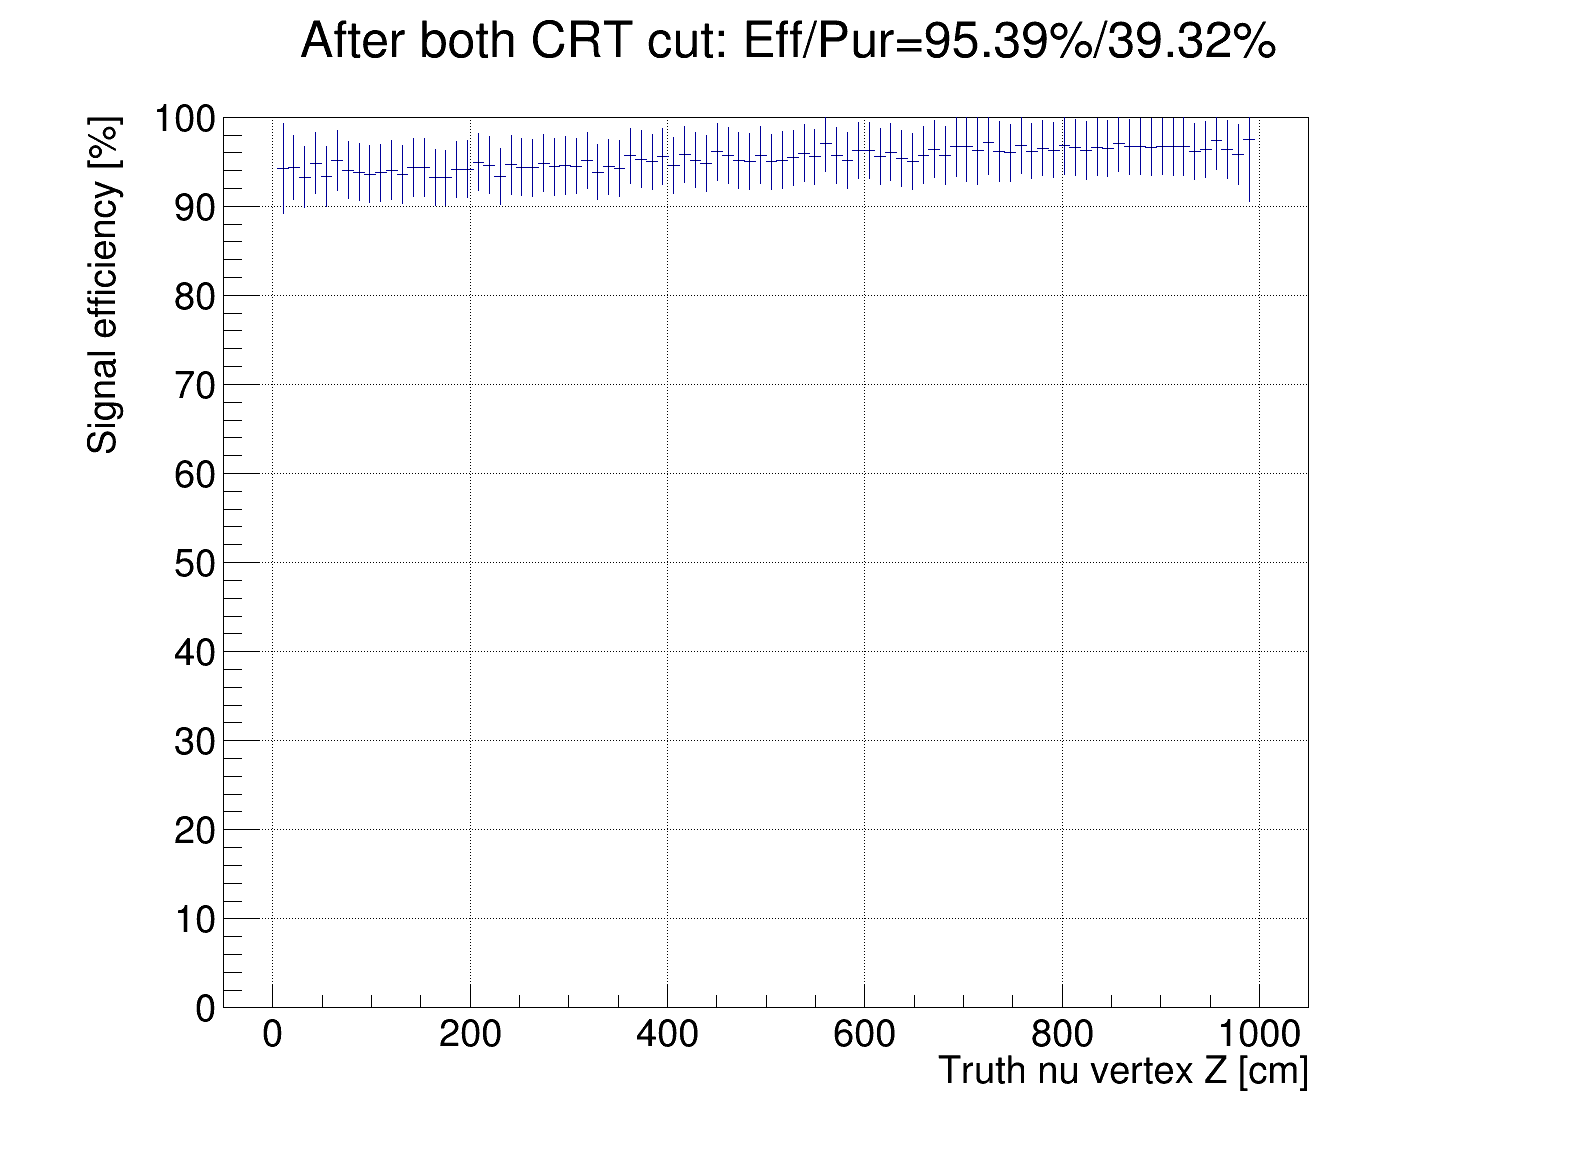

In [19]:
xstart = 0
xend = 8
xbin = 100

nenner_cut = "numu_signal && muon && fidVol"
zahler_cut = "numu_signal && fidVol && muon && (nr_crthit_beam_tres<1 || track_end_uncontained) && (!track_end_uncontained || crt_cut)"
cut = 'fidVol && muon && (nr_crthit_beam_tres<1 || track_end_uncontained) && (!track_end_uncontained || crt_cut)'

efficiency = overlay.GetEntries(zahler_cut)*100.0/overlay.GetEntries(nenner_cut)
purity = overlay.GetEntries(cut+' && numu_signal')*scale[overlay]*100/NuCC.getTotNum(cut)

print 'Efficiency:\t{0:0.2f}%'.format(efficiency)
print 'Purity:\t\t{0:0.2f}%'.format(  purity)


name = '_CRTcutAll'
title = 'After both CRT cut:'
title = title+' Eff/Pur={0:0.2f}%'.format( efficiency)+'/{0:0.2f}%'.format(purity)

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Energy>>h_init_eff_energy',zahler_cut)
overlay.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
h_init_eff_energy.Scale(100)
h_init_eff_energy.SetMaximum(100)
h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth enutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_energy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_energy"+name+".root")


xstart = -1
xend = 1
xbin = 100
h_init_eff_theta = ROOT.TH1F("h_init_eff_theta",title,xbin,xstart,xend)
h_init_eff_theta_1 = ROOT.TH1F("h_init_eff_theta_1",title,xbin,xstart,xend)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta',zahler_cut)
overlay.Draw('cos(MCNu_leptonTheta)>>h_init_eff_theta_1',nenner_cut)
h_init_eff_theta_1.Sumw2()
h_init_eff_theta.Divide(h_init_eff_theta_1)
h_init_eff_theta.Scale(100)
h_init_eff_theta.SetMaximum(100)
h_init_eff_theta.SetMinimum(0)
h_init_eff_theta.SetXTitle("Truth neutrino cos(theta)")
h_init_eff_theta.SetYTitle("Signal efficiency [%]")
h_init_eff_theta.Draw("E")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_theta"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_theta"+name+".root")

xstart = -3.14159
xend = 3.14159
xbin = 100
h_init_eff_phi = ROOT.TH1F("h_init_eff_phi",title,xbin,xstart,xend)
h_init_eff_phi_1 = ROOT.TH1F("h_init_eff_phi_1",title,xbin,xstart,xend)
overlay.Draw('TrackPhi>>h_init_eff_phi',zahler_cut)
overlay.Draw('TrackPhi>>h_init_eff_phi_1',nenner_cut)
h_init_eff_phi_1.Sumw2()
h_init_eff_phi.Divide(h_init_eff_phi_1)
h_init_eff_phi.Scale(100)
h_init_eff_phi.SetMaximum(100)
h_init_eff_phi.SetMinimum(0)
h_init_eff_phi.SetXTitle("Reco neutrino phi [pi]")
h_init_eff_phi.SetYTitle("Signal efficiency [%]")
h_init_eff_phi.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_phi"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_phi"+name+".root")

xstart = -50
xend = 300
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vx>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vx>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex X [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vx"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vx"+name+".root")

xstart = -150
xend = 150
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vy>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vy>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Y [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vy"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vy"+name+".root")

xstart = -50
xend = 1050
xbin = 100
h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
overlay.Draw('MCNu_Vz>>h_init_eff_V',zahler_cut)
overlay.Draw('MCNu_Vz>>h_init_eff_V_1',nenner_cut)
h_init_eff_V_1.Sumw2()
h_init_eff_V.Divide(h_init_eff_V_1)
h_init_eff_V.Scale(100)
h_init_eff_V.SetMaximum(100)
h_init_eff_V.SetMinimum(0)
h_init_eff_V.SetXTitle("Truth nu vertex Z [cm]")
h_init_eff_V.SetYTitle("Signal efficiency [%]")
h_init_eff_V.Draw("e")
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(outputdir_root + "h_eff_Vz"+name+".root")

